In [18]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns

Vamos trabalhar com o dataset de classificação de cancer

In [19]:
# Importing the dataset
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
breast_cancer_wisconsin_diagnostic = fetch_ucirepo(id=17) 
  
# data (as pandas dataframes) 
X = breast_cancer_wisconsin_diagnostic.data.features 
y = breast_cancer_wisconsin_diagnostic.data.targets

dataset = pd.concat([X, y], axis=1)

# Transforma a coluna de diagnóstico em 0 e 1
dataset['Diagnosis'] = dataset['Diagnosis'].map({'M': 1, 'B': 0})
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   radius1             569 non-null    float64
 1   texture1            569 non-null    float64
 2   perimeter1          569 non-null    float64
 3   area1               569 non-null    float64
 4   smoothness1         569 non-null    float64
 5   compactness1        569 non-null    float64
 6   concavity1          569 non-null    float64
 7   concave_points1     569 non-null    float64
 8   symmetry1           569 non-null    float64
 9   fractal_dimension1  569 non-null    float64
 10  radius2             569 non-null    float64
 11  texture2            569 non-null    float64
 12  perimeter2          569 non-null    float64
 13  area2               569 non-null    float64
 14  smoothness2         569 non-null    float64
 15  compactness2        569 non-null    float64
 16  concavit

In [20]:
# find if dataset has any NaN value
dataset.isnull().sum()

radius1               0
texture1              0
perimeter1            0
area1                 0
smoothness1           0
compactness1          0
concavity1            0
concave_points1       0
symmetry1             0
fractal_dimension1    0
radius2               0
texture2              0
perimeter2            0
area2                 0
smoothness2           0
compactness2          0
concavity2            0
concave_points2       0
symmetry2             0
fractal_dimension2    0
radius3               0
texture3              0
perimeter3            0
area3                 0
smoothness3           0
compactness3          0
concavity3            0
concave_points3       0
symmetry3             0
fractal_dimension3    0
Diagnosis             0
dtype: int64

Em geral, o dataframe já veio todo tratado. Então a parte de tratamento de dados é meio que nula. Não tem nenhum dado NA e todos as features são do tipo float.

<Axes: >

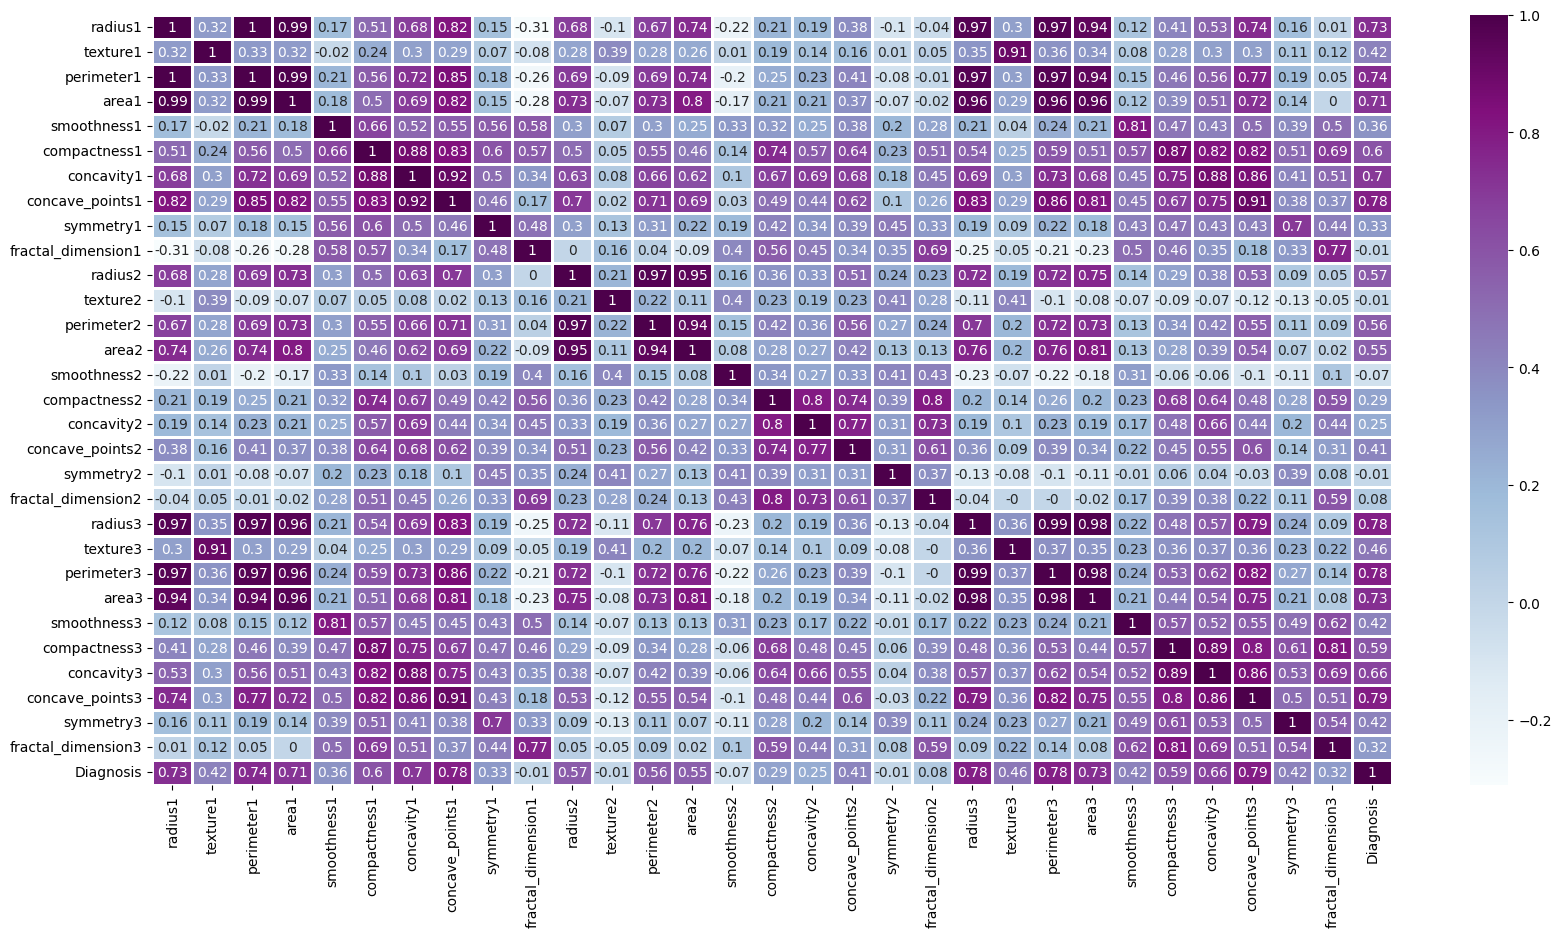

In [21]:
# Aumenta o figsize
plt.figure(figsize=(20, 10))
sns.heatmap(dataset.corr().round(2), annot=True, cmap='BuPu', linewidths=2)

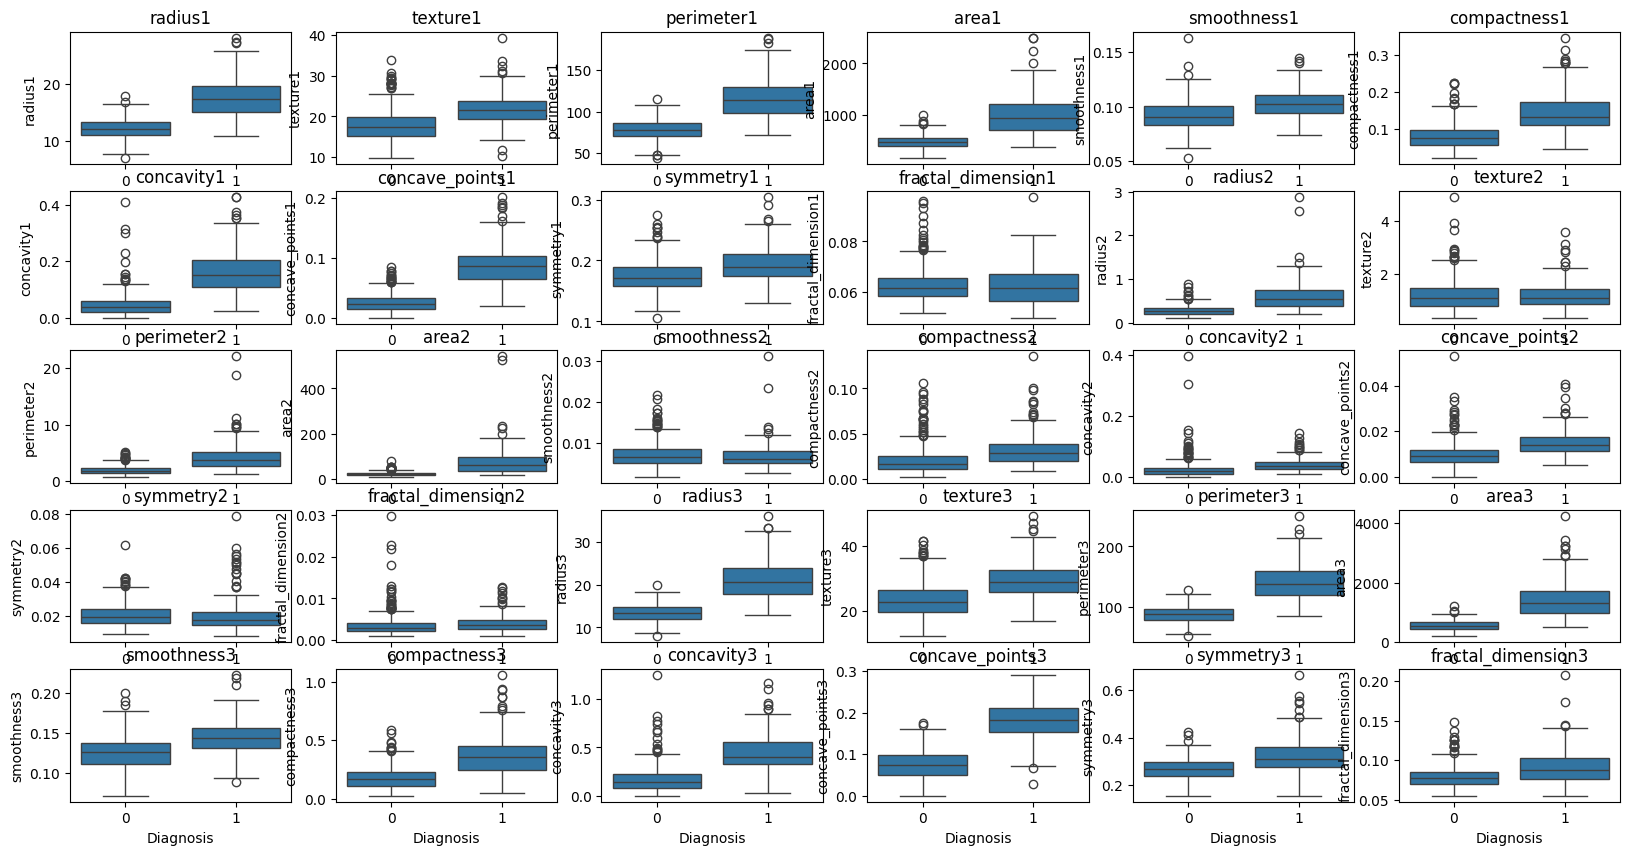

In [22]:
# Plota boxplots
plt.figure(figsize=(20, 10))
for i, column in enumerate(dataset.columns[:-1]): # Exclui a última coluna, que é a coluna de diagnóstico
    plt.subplot(5, 6, i+1)
    sns.boxplot(x='Diagnosis', y=column, data=dataset)
    plt.title(column)

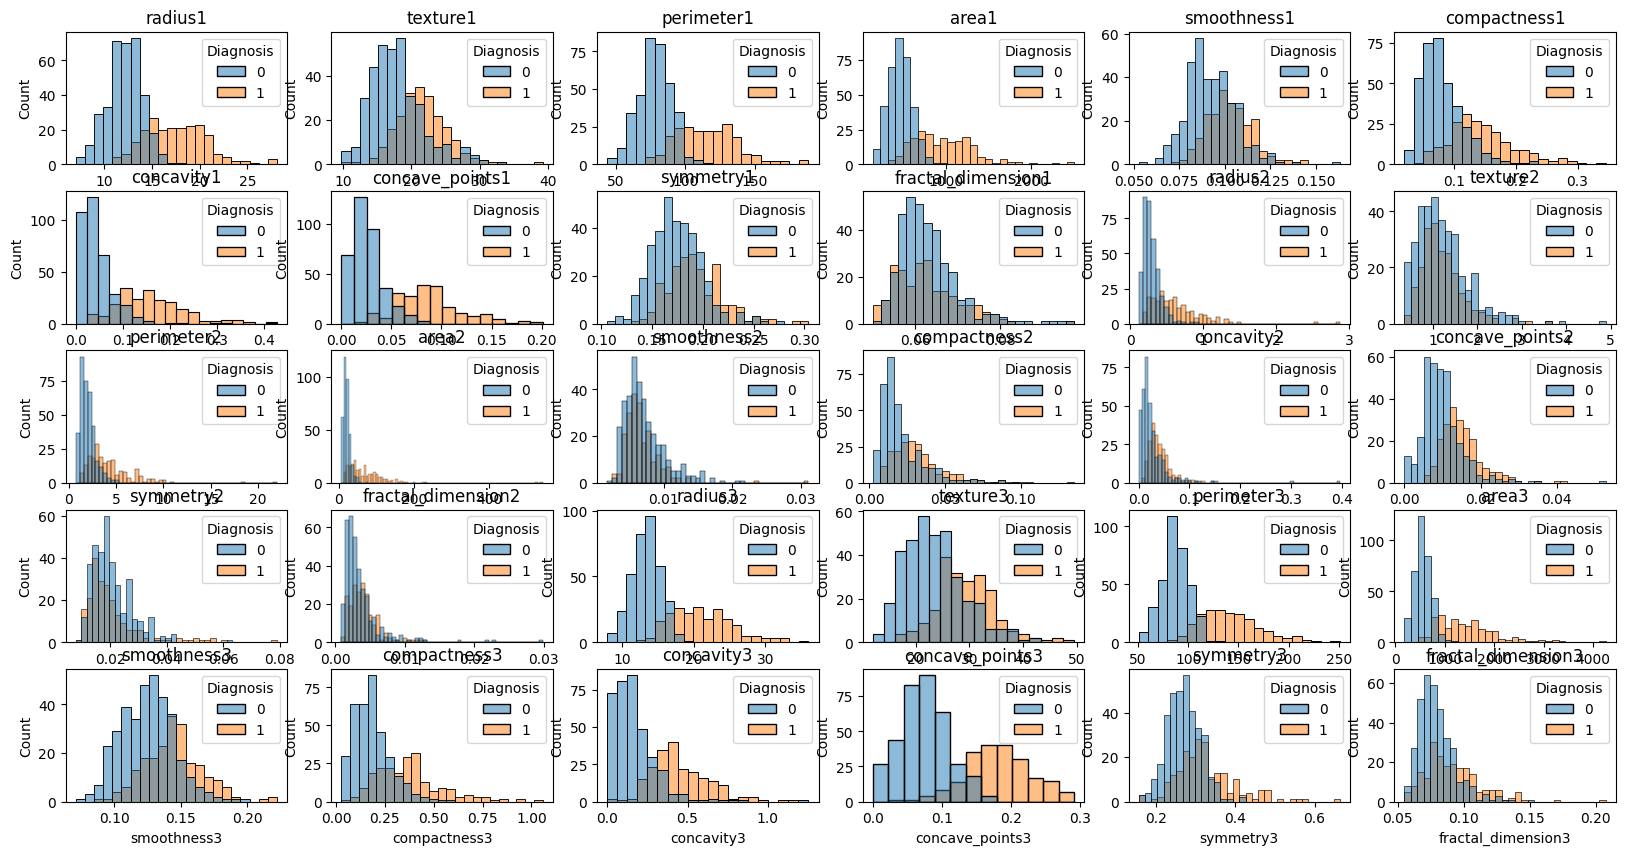

In [23]:
# Plota histograma
plt.figure(figsize=(20, 10))
for i, column in enumerate(dataset.columns[:-1]): # Exclui a última coluna, que é a coluna de diagnóstico
    plt.subplot(5, 6, i+1)
    sns.histplot(data=dataset, x=column, hue='Diagnosis', kde=False)
    plt.title(column)

In [24]:
# Cria as variáveis independentes e dependentes
X = dataset.drop(['Diagnosis'], axis=1).copy()
y = dataset['Diagnosis'].copy()

display(sum(y)/len(y)) # Proporção de diagnósticos malignos

0.37258347978910367

Vemos que 37% são classificados como malignos. Então, quando formos dividir os dados em treino e teste, precisamos garantir que ambas amostras tenham a mesma porcentagem de classificação 
maligna

Para isso, vamos usar stratify

In [25]:
# Splitting the dataset into the Training set and Test set
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 33, stratify=y)

In [26]:
sum(y_train)/len(y_train), sum(y_test)/len(y_test) # Proporção de diagnósticos malignos

(0.37362637362637363, 0.3684210526315789)

In [27]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [28]:
# Treinando o modelo
model = xgb.XGBClassifier(objective='binary:logistic', seed=33)
model.fit(X_train, 
          y_train,
          #verbose=True, # mostra o progresso do treinamento
          #eval_set=[(X_test, y_test)], # conjunto de validação
          #early_stopping_rounds=10, # interrompe o treinamento se não houver melhora por 10 rodadas
          #eval_metric=mean_absolute_error # métrica de avaliação
          )

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

<Axes: >

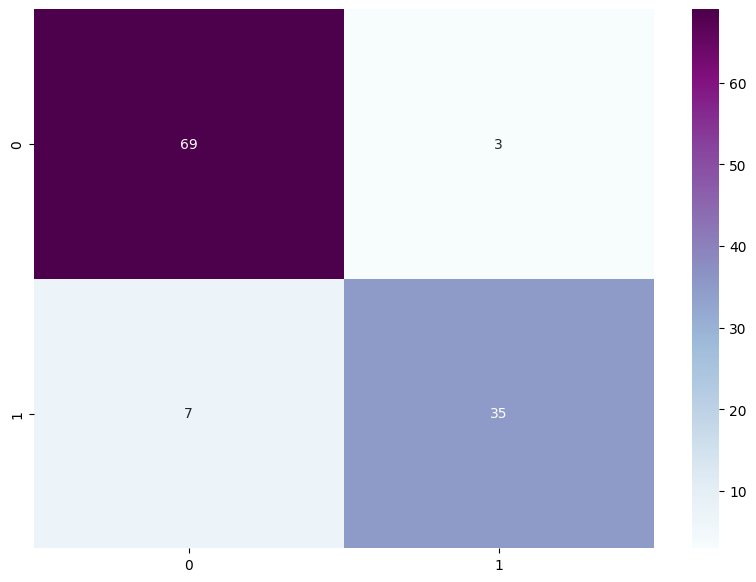

In [29]:
# Plota matriz de confusão
from sklearn.metrics import confusion_matrix
y_pred = model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='BuPu', fmt='d')

In [30]:
# Printa acurácia
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_pred)

0.9122807017543859

# Aprimorando o modelo - otimizando hiperparametros

In [31]:
# Optimize hyperparameters
from sklearn.model_selection import GridSearchCV
parameters = {'max_depth': [3, 4, 5], 
              'learning_rate': [0.01, 0.1, 0.3],
              'gamma': [0, 0.1, 0.2],
              'reg_lambda': [0, 1, 10]}

grid_search = GridSearchCV(estimator=model,
                            param_grid=parameters,
                            scoring='accuracy',
                            cv=3,
                            n_jobs=-1)
grid_search = grid_search.fit(X_train, y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

best_accuracy, best_parameters

(0.9736261182758219,
 {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'reg_lambda': 1})

In [32]:
# Treinando o modelo com os melhores parâmetros
opt_model = xgb.XGBClassifier(objective='binary:logistic', 
                              seed=33,
                              max_depth=5,
                              learning_rate=0.1,
                              gamma=0,
                              reg_lambda=1)

opt_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

<Axes: >

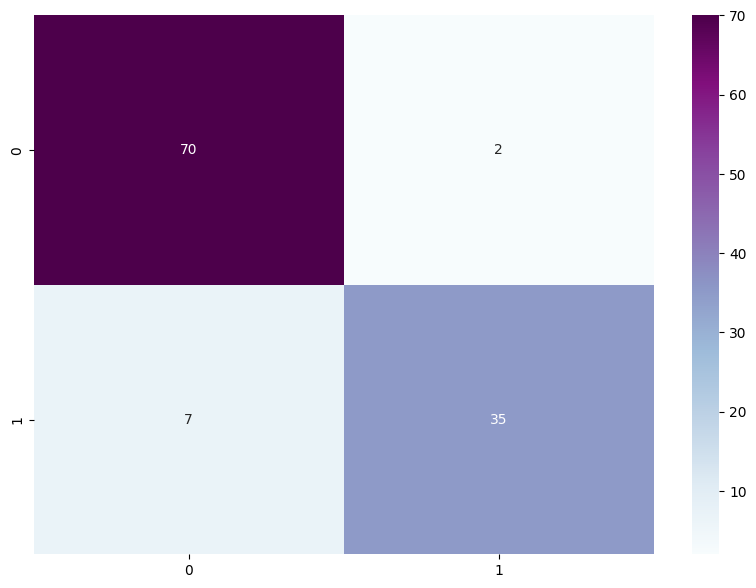

In [33]:
# Plota matriz de confusão
y_pred = opt_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, cmap='BuPu', fmt='d')